In [1]:
from collections import defaultdict

## see examples in https://www.gurobi.com/resource/modeling-examples-using-the-gurobi-python-api-in-jupyter-notebook/
import gurobipy as gp
from gurobipy import GRB

import math
import numpy as np
import sys

from fruit_distribution import *   # import module to create the various desired fruit distributions 
from IG_data_analysis import *     # import module to analyze the data from the snapshots

# tested with Python 3.7.0 & Gurobi 9.0

## based on the Gurobi technician routing scheduling example
# https://gurobi.github.io/modeling-examples/technician_routing_scheduling/technician_routing_scheduling.html

In [2]:
## Functions
def getRNGSeedList(n_runs):
        '''
           Open the random seed list rngseed_list_20200901.csv with 200 seeds for each of the 3 real fruit coordinate axis
           and 3 fake fruit coordinate axis.
        '''
        # keeps track of the row number of the csv being read (each row contains the seeds for one run)
        csv_i     = 0

        seed_list = list()

        with open('./rngseed_list_20200901.csv') as csvfile:
            reader = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
            for row in reader:
                seed_list.append(row)
                if csv_i == n_runs:
                    break

                csv_i += 1

        # print(seed_list)
        return(seed_list)
    
    
def createFruit(fruitD, set_algorithm, set_distribution, density, x_seed, y_seed, z_seed):
        if set_distribution == 0:
            csv_file = './TREE_FRUIT_DATA/apple_tree_data_2015/Applestotheright.csv'
            [numFruit, sortedFruit] = fruitD.csvFile(csv_file, 0)

        elif set_distribution == 1:
            if set_algorithm == 1:
                [numFruit, sortedFruit] = fruitD.uniformRandomMelon(density, y_seed, z_seed)
            else:
                [numFruit, sortedFruit] = fruitD.uniformRandom(density, x_seed, y_seed, z_seed)
            # print()
            # print('--------------------------------------------')
            # print('Number of fruit:', numFruit)
            # print()

        elif set_distribution == 2: 
            fruit_in_cell = math.ceil(density * (cell_h*cell_l*arm_reach)) # num of fruit in front of cell if using (equalCellDensity())
            print('Number of fruit in each cell:', fruit_in_cell)
            print()
            [numFruit, sortedFruit] = fruitD.equalCellDensity(n_row, n_arm, cell_h, cell_l, arm_reach, fruit_in_cell, x_seed, y_seed, z_seed)

        elif set_distribution == 3: 
            densities = np.array([5, 4, 3])
            [numFruit, sortedFruit] = fruitD.uniformRandomMelon_MultipleDensity(densities, y_seed, z_seed)

        elif set_distribution == 4: 
            [numFruit, sortedFruit] = fruitD.column(v_vy, v_max, a_max, t_grab, n_row, n_arm, cell_h, z_seed)
            
        elif set_distribution == 5:
            z_coord = cell_h / 2
            n_fruit = math.floor((y_lim[1] - y_lim[0]) * density) # the total number of fruit 
            d_y     = 1 / density                               # in m, the distance between each fruit
            
            [numFruit, sortedFruit] = fruitD.columnUniform_melon(n_fruit, d_y, z_coord)

        else: 
            print('not a correct fruit distribution, defaulting to uniform random')
            if set_algorithm == 1:
                [numFruit, sortedFruit] = fruitD.uniformRandomMelon(density, y_seed, z_seed)
            else:
                [numFruit, sortedFruit] = fruitD.uniformRandom(density, x_seed, y_seed, z_seed)

        return([numFruit, sortedFruit])
    
    
def calc_TW(arm_n, y_coord, v_vy):
    TW_start = (y_coord + (arm_n - 1)*l) / v_vy
    TW_end   = (y_coord + arm_n*l) / v_vy
    return([TW_start, TW_end])


def getHorizonIndex(sortedFruit, q_vy, vehicle_l, horizon_l):
    '''
    Saves this snapshot's horizon fruit indexes based on the sortedFruit indexes to 
    compare and remove picked fruit.
    '''
    # edges of the horizon based on vehicle location and length
    horizon_back  = q_vy + vehicle_l
    horizon_front = horizon_back + horizon_l

    H_fruit_index = np.where((sortedFruit[1,:] >= horizon_back) & (sortedFruit[1,:] < horizon_front))

    return(H_fruit_index[0])


def calcDensity(q_vy, v_vy, n_row, n_arm, cell_l, cell_h, arm_reach, sortedFruit):
    '''Get the fruit density, d, of each cell'''
    ## should the columns be based on cell length? number of arms? 
    #  should the columns be the same width? increase/decrease the closer to the front of vehicle?
    #  should I calculate R per horizontal row of arms?

    d = np.zeros([n_row, n_arm])  # total number of cells
    # starting position on the z-axis (up-down on robot)
    row_z = 0.

    for n in range(n_row):
        # starting position in the y_axis (front-back on robot)
        col_y = q_vy

        for k in range(n_arm):
            # print('col', n, 'row', k)
            # print('back', col_y, 'front', col_y + cell_l)
            # print('bottom', row_z, 'top', row_z + cell_h)
            index = np.where((sortedFruit[1,:] >= col_y) & (sortedFruit[1,:] < col_y + cell_l) & 
                        (sortedFruit[2,:] >= row_z) & (sortedFruit[2,:] < row_z + cell_h) & 
                        (sortedFruit[4,:] < 1))
            # save the number of fruit in this cell
            d[n,k] = len(index[0])
            # print(d)
            # move to the next column of cells
            col_y += cell_l

        # move up to the next cell on this column
        row_z += cell_h

    # before calculating the true density, check total number of fruit
    # print('which sums to', np.sum(d))   # has to be equal to numer of fruit
    # divide all the values by the volume of space in front of each cell 
    d = d / (arm_reach * cell_l * cell_h)

    # print('fruit density in each cell [fruit/m^3]:')
    # print(d)

    return(d)


def calcR(v_vy, fruit_in_horizon, horizon_l, vehicle_h, arm_reach):
    '''Calculate the R value given a speed and horizon volume and density'''
    try:
        density_H = fruit_in_horizon / (horizon_l * vehicle_h * arm_reach)
        time_H    = horizon_l / v_vy

        R         = density_H / time_H # in fruit / (m^3 * s)

    except ZeroDivisionError:
        R         = 0 

    # print('Fruit incoming rate based on the horizon [fruit/(m^3 s)]:')
    # print(R)
    return(R) 

def calcStateTime(fruit_picked_by, travel_l, v_vy, total_arms, n_row, n_arm, Td):
    # def calculateStateTimePercent(self, fruit_picked_by, total_distance):
        '''Calculates the time each arm is in each state so that it can plotState can plot the data'''
        # total_distance = self.y_lim[1] - self.y_lim[0]
        total_distance = travel_l
        total_time = total_distance / v_vy  # for snapshots? -> I'm deleting Tm and Tw data at each snapshot, problem
#         print('movement distance:', total_distance)
#         print('total move time:', total_time)

        ## states: idle, pick_yz, pick_x, grab, retract_x, move_z/unload
        # self.state_percent = np.zeros([self.total_arms, 6]) # save each arm's percent time in each of the six states 
        state_time = np.zeros([total_arms, 7]) # save each arm's percent time in each of the six states plus a total

        for n in range(n_row):
            for k in range(n_arm):
                tot_arm_index = k + (n*n_arm)
                # # calculate arm's move_yz using Tm
                # for tm in self.Tm_values[n][k]:
                #     self.state_time[tot_arm_index,1] += tm

                if n_row > 1:
                    num_picked = len(fruit_picked_by[n][k])
#                     print('arm', k, 'picked', num_picked, 'fruit, from', fruit_picked_by[n][k])
                else:
                    num_picked = len(fruit_picked_by[k])
#                     print('arm', k, 'picked', num_picked, 'fruit, from', fruit_picked_by[k])
                    
                busy = num_picked * Td
#                 print('so was busy', busy, 'total seconds')
#                 print()
                state_time[tot_arm_index,1] = busy  # setting Tm as the "handling time"

                # calculate idle by subtracting all before by total time: length_row / v
                state_time[tot_arm_index,0] = total_time - np.sum(state_time[tot_arm_index,:])
                # save the total time for this run to get total percent later
                state_time[tot_arm_index,6] = total_time
                
        return(state_time)

In [3]:
## Constants 
## to print out from data analysis
print_out  = 1
plot_out   = 1

## settings
Td         = 2.      # fruit handling time
M          = 80     # arbitrarily large number, set 600 from paper
# v_vy_fruit = 0.3     # in m/s, assumed vehicle velocity along orchard row to build line distribution
v_vy_fruit_cmps = 30
q_vy       = 0.      # in m, backmost, lowest coordinate of the vehicle

v_max      = 0.5
a_max      = 1.
t_grab     = 0.1 

n_row      = 1       # total number of horizontal rows with cells containg one arm per cell
n_arm      = 3       # number of arms in one horizontal row

density    = 3       # in fruit/m^2, makespan is being limited to rho = 2 with random placement
n_fruit    = 120      # in fruit, for melon column distribution

FPE_min    = 0.95

noRel_time_ub  = 300  # no relaxation heuristic max time to solve before moving to branch and bound (varies)
timLim_time_ub = 3600*1/3
v_vy_ub_cmps   = (170 * n_arm) + 10  # in cm/s, the upper allowed bound of the vehicle velocity

l          = 0.3     # in m, length of the cell along the orchard row (y-axis), parallel to vehicle travel
w          = 2.      # in m, width/height of the horizontal row of arms (z-axis) perpendicular to vehicle travel

cell_l     = l
cell_h     = w
arm_reach  = 1.

vehicle_l  = n_arm * cell_l
vehicle_h  = n_row * cell_h

## for future addition of snapshots
horizon_l  = 0.

## set fruit distribution flag
# 0     == Raj's digitized fruits
# 1     == uniform random  (if algorithm == 1, use melon version)
# 2     == uniform random, equal cell density
# 3     == multiple densities separated by some space (only melon for now)
# 4     == fruit in vertical columns
# 5     == "melon" version of columns (user inputs desired no. fruits, z height, and distance between fruit in y-coord)
set_distribution = 5

## set algorithm being used 
# 1     == melon
# not 1 == not melon
set_algorithm    = 1

## set MIP model settings
# 0     == basic MIP model from the melon paper
# 1     == basic MIP model with velocity as a variable
set_MIPsettings  = 1

n_snapshots = 1 # for now a constant


In [4]:
## Get fruit list based on desired distribution
n_runs = 1

seed_list = getRNGSeedList(n_runs)

for run in range(n_runs):
    # get seeds for x, y, and z RNG (probably unneccessary right now, especially for x)
    seed = [seed_list[run][0], seed_list[run][1], seed_list[run][2]]
    x_seed = PCG64(int(seed[0]))
    y_seed = PCG64(int(seed[1]))
    z_seed = PCG64(int(seed[2]))
    
if set_distribution == 0:
    travel_l  = 12 + vehicle_l # in m
    density   = 48.167         # in fruit/m^2 (on avg.), constant
    n_runs    = 1

elif set_distribution == 1:
    travel_l  = 5 + vehicle_l # in m

elif set_distribution == 3:
    travel_l  = 30 + vehicle_l # in m
    
elif set_distribution == 5:
    # to get distance between fruit perfect for a specific ideal/set velocity v_vy_fruit_cmps
#     v_vy_fruit_mps = v_vy_fruit_cmps / 100
#     d_y  = Td*v_vy_fruit_mps*(n_fruit+1)/(n_fruit+2) # kind of works 3/4 or 5/8 fruit with 1 arm: (Td/2)*v_vy
#     print('with Td', Td, 'and v_vy for fruit distribution', v_vy_fruit_cmps, 'cm/s')
#     print('d_y for this line of fruit:', d_y, 'so the total distance they take up:', d_y*n_fruit)
#     travel_l  = d_y * n_fruit + vehicle_l # in m

    # to get a specific number of fruit at a specific 1D density 
    total_dy = math.floor(n_fruit / density) # in m, the total distance needed to have the right density and right number of fruit
    travel_l  = total_dy + vehicle_l # in m
    
else: 
    travel_l  = 10 + vehicle_l # in m 
    
x_lim   = [0.2, 1.2]
y_lim   = [0. , travel_l - vehicle_l]
z_lim   = [0., 2.] 

fruitD = fruitDistribution(x_lim, y_lim, z_lim)
[numFruit, sortedFruit] = createFruit(fruitD, set_algorithm, set_distribution, density, x_seed, y_seed, z_seed)

print('Total fruit in the orchard row',numFruit)
# print()
# print('List of the x, y, and z coordinates of the sorted fruit')
# print(sortedFruit)

# array to save which arm picked which fruit
curr_j = np.zeros([n_row, n_arm])

Total fruit in the orchard row 120


In [5]:
class Arm():
    def __init__(self, row_n, arm_n):
        self.row_n = row_n
        self.arm_n = arm_n

    def __str__(self):
        return f"Arm: {self.arm_n}\n Horizontal Row Number: {self.row_n}"

In [6]:
class Fruit():
    def __init__(self, index, y_coord, z_coord):#, job, tStart, tEnd, tDue):
        self.index = index       # fruit's index when ordered by y-coordinate
        self.y_coord = y_coord   # y-coordinate of the fruit
        self.z_coord = z_coord
        
    def __str__(self):
        return f"Fruit Index: {self.index}\n  Y-axis location: {self.y_coord}\n"

In [7]:
class Job_v_vy():
    # for basic MIP with vehicle velocity as a variable
    def __init__(self, fruit_i, arm_k):
        self.fruit_i = fruit_i
        self.arm_k   = arm_k

In [8]:
## create arm object list
arm = list()

for r in range(n_row):
# for r in range(1, n_row+1):
    for k in range(n_arm):
#     for k in range(1, n_arm+1):
        this_arm = Arm(r, k)
        arm.append(this_arm)
    
# print(arm)

In [9]:
## create fruit object list
fruit = list()

for index in range(numFruit):
    y_coord = sortedFruit[1][index]
    z_coord = sortedFruit[2][index]
    this_fruit = Fruit(index, y_coord, z_coord)
#     print('Fruit index', index, 'should match this index', sortedFruit[3][index])
#     print('with y and z coordinates:', y_coord, z_coord)

    fruit.append(this_fruit)

# print(fruit)

In [10]:
## create job oject list
job = list()

for k in arm:
    for i in fruit:  
        this_job = Job_v_vy(i, k)
#         
#         print('for arm', this_job.arm_k.arm_n, 'and fruit', this_job.fruit_i.index)
#         print('TW starts at', this_job.TW_start, 'and TW ends at', this_job.TW_end)
        job.append(this_job)
    
# print(len(job))
# print(len(arm)*len(fruit))

In [11]:
def solve_melon_mip(arm, fruit, job):
    ## Build useful data structures
    # lists:
    K = [k.arm_n for k in arm]      # list of arm numbers
    N = [i.index for i in fruit]    # list of fruit indexes
    Y = [i.y_coord for i in fruit]  # list of fruits' y-coordinate (x-coordinate in the paper)
#     print('number of arms:',K, 'with length', len(K))
#     print()
#     print('number of fruits:',N, 'with length', len(N))
#     print()
#     print('fruit y-coordinate:', Y, 'with length', len(Y))
#     print()

    total_fruit = len(N) # needed to constraint FPE to a high picking percentage

    
    ### Create model
    m = gp.Model("makespan_mip")
    
    
    ### change needed model parameters
    ### see https://www.gurobi.com/documentation/9.5/refman/python_parameter_examples.html#PythonParameterExamples
    # if velocity becomes a variable, it is multiplied with another variable requiring the following settings
    m.params.NonConvex = 2
    m.setParam('NonConvex', 2)
    
    # Due to *very* high complexity, limits time in the no relaxation heuristic
    # see https://www.gurobi.com/documentation/9.5/refman/norelheurtime.html
    m.setParam('NoRelHeurTime', noRel_time_ub)
    
    # limit the maximum amount of time the solver takes to find a solution -> if gap isn't 0% then "no solution"
    # if NoRel == TimeLimit, only NoRel used (https://support.gurobi.com/hc/en-us/community/posts/4414052781073-NoRel-and-setting-time-limits)
    m.setParam('TimeLimit', timLim_time_ub) # stop after half an hour
    
    
    ### Decision variables
    # Arm-fruit assignment (is fruit i picked by arm k)
    x = m.addVars(K, N, vtype=GRB.BINARY, name="x")
    
    # Time arm k reaches fruit i
    t_ub = (travel_l + l) / (l/Td)
    
    t = m.addVars(K, N, lb=0, ub=t_ub, name="t")
    
    # Start and end of time window arm k can reach fruit i
    tw_s_ub = travel_l / (l/Td) 
    tw_e_ub = (travel_l + l) / (l/Td) 
    
    tw_s = m.addVars(K, N, lb=0, ub=tw_s_ub, name="tw_s")
    tw_e = m.addVars(K, N, lb=0, ub=tw_e_ub, name="tw_e")

    # required because gurobi doesn't like >= or <= constraints that deal with two variables
    aux_max = m.addVars(K, N, lb=0, name="aux_max")
    aux_min = m.addVars(K, N, lb=0, name="aux_min")

    # in m/s, vehicle velocity along orchard row
    # bounded by the cell length and Td (melon paper) and bounded by max velocity of the lift (90 cm/s)
    v_vy_lb_cmps = math.ceil(l / Td * 100) # chose to make into integer, ceil because smaller won't work
#     v_vy_lb = l / Td 
    v_vy = m.addVar(vtype=GRB.INTEGER, lb=v_vy_lb_cmps, ub=v_vy_ub_cmps, name="v_vy")
#     v_vy = m.addVar(lb=v_vy_lb, ub=v_vy_ub, name="v_vy")
    # add a starting guess value to the variable
    # see https://www.gurobi.com/documentation/9.5/refman/start.html#attr:Start
#     v_vy.start = 61 # in cm/s
    
    # create a variable that saves the last picking time, or makespan
    makespan  = m.addVar(lb=0, name="makespan")
    t_max_arm = m.addVars(K, name='t_max')  # max t value for each arm
    
    
    ### Constraints
    # At most one arm can be assigned to a fruit (1)
    m.addConstrs((x.sum('*', i) <= 1 for i in N), name="assignOne")
    
    # Time elapsed between pickup of any two fruit reached by the same arm is at least Td (2)
    m.addConstrs((t[k, i] + Td - t[k, j] <= M * (2 - x[k, j] - x[k, i]) for i in N for j in N for k in K if Y[j] > Y[i]), name="atLeast")
        
    ##### ********* Relax the time window and velocity constraints ********* #####
#     u1 = m.addVars(K, N, lb=-gp.GRB.INFINITY, name="u1")
#     u2 = m.addVars(K, N, lb=-gp.GRB.INFINITY, name="u2")
#     epsilon_min = m.addVar(ub=epsilon, name="epsilon_min")
#     epsilon_max = m.addVar(ub=epsilon, name="epsilon_max") 
    
#     m.addConstrs(((u1[k, i] == tw_s[k, i] * v_vy - (Y[i] + k * l)) for i in N for k in K), name="TW_start")
#     m.addConstrs(((u2[k, i] == tw_e[k, i] * v_vy - (Y[i] + (k + 1) * l)) for i in N for k in K), name="TW_end")

#     m.addConstrs(((epsilon_min == gp.abs_(u1[k, i]) for i in N for k in K)), name="TW_start_relaxed")
#     m.addConstrs(((epsilon_max == gp.abs_(u2[k, i]) for i in N for k in K)), name="TW_end_relaxed")
    
    #### ******************************************************************* #####
    m.addConstrs(((tw_s[k, i] * (v_vy / 100) == (Y[i] + k * l)) for i in N for k in K), name="TW_start")
    m.addConstrs(((tw_e[k, i] * (v_vy / 100) == (Y[i] + (k + 1) * l)) for i in N for k in K), name="TW_end")
    
    # to learn how to deal with max/min with variables
    # see https://support.gurobi.com/hc/en-us/community/posts/360076808711-how-to-add-a-max-constr-General-expressions-can-only-be-equal-to-a-single-var
    m.addConstrs((aux_max[k, i] == gp.max_(tw_s[k, i], tw_e[k, i]) for i in N for k in K), name="auxMax")
    m.addConstrs((aux_min[k, i] == gp.min_(tw_s[k, i], tw_e[k, i]) for i in N for k in K), name="auxMin")
#     m.addConstrs((aux_max[k, i] == gp.max_(tw_s[k, i], tw_e[k, i]) for i in N for k in K), name="auxMax")
#     m.addConstrs((aux_min[k, i] == gp.min_(tw_s[k, i], tw_e[k, i]) for i in N for k in K), name="auxMin")

    # Ensure each node is visited within the given time window (3) and (4)
    # TW_start and TW_end are matching the fruit index number exactly (disctionary), so [2][0] == index 2 (even 
    # though it starts at zero, second arm back from 0th arm)  
    m.addConstrs(((t[k, i] <= aux_max[k, i]) for i in N for k in K), name="timeWinA")
    m.addConstrs(((t[k, i] >= aux_min[k, i]) for i in N for k in K), name="timeWinB")
    
    # Ensure at least 90% (or desired percentage) of available fruit are harvested
    m.addConstr((gp.quicksum(x[k, i] for i in N for k in K)/total_fruit >= FPE_min), name="percentHarvest")
    
    # set makespan as the latest t^k_i value
    # see https://support.gurobi.com/hc/en-us/community/posts/360071830171-Use-index-of-decision-variable-in-max-constraint
    m.addConstrs((t_max_arm[k] == gp.max_(t.select(k, '*')) for k in K), name='max_value')
    
#     makespan = m.addVar(name='makespan')
    m.addConstrs((makespan >= t_max_arm[k] for k in K), name='makespan_contraint')
    
    
    ### Objective function
#     m.setObjective(gp.quicksum(x[k, i] for i in N for k in K), GRB.MAXIMIZE)
    m.setObjective((makespan), GRB.MINIMIZE)
    
    ## see https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.03-Job-Shop-Scheduling.ipynb
    ## and https://support.gurobi.com/hc/en-us/community/posts/360071830171-Use-index-of-decision-variable-in-max-constraint
    
    ## write model into a file
    # see https://www.gurobi.com/documentation/9.5/refman/py_model_write.html
    # https://www.gurobi.com/documentation/9.5/refman/model_file_formats.html
    m.write("makespan_mip.lp")
    m.write("makespan_mip.mps")
    m.optimize()

    status = m.Status
    if status in [GRB.INF_OR_UNBD, GRB.INFEASIBLE, GRB.UNBOUNDED]:
        print("Model is either infeasible or unbounded.")
        sys.exit(0)
    elif status != GRB.OPTIMAL:
        print("Optimization terminated with status {}".format(status))
#         sys.exit(0)
        
    
    fruit_picked_by = list()    
        
    for n in range(n_row):
        if n_row > 1:
            fruit_picked_by.append([])
            
        for k in range(n_arm+1):
            if n_row > 1:
                fruit_picked_by[n].append([])
            else:
                fruit_picked_by.append([])
            
    ### Print results
    # Assignments    
#     print()
    for j in job:
        if x[j.arm_k.arm_n, j.fruit_i.index].X > 0:
#             print('fruit', j.fruit_i.index, 'assigned to arm', j.arm_k.arm_n, 'at t = ', t[j.arm_k.arm_n, j.fruit_i.index].X)
#             if set_MIPsettings == 1:
#                 print('with tw start:', aux_min[j.arm_k.arm_n, j.fruit_i.index].X, 'and tw end:', aux_max[j.arm_k.arm_n, j.fruit_i.index].X)
            # save picked to sortedFruit
            if sortedFruit[4, j.fruit_i.index] == 1:
                # print out an error message, NoRel has shown that it can cause issues
                print()
                print('********* ERROR: fruit', j.fruit_i.index, 'has already been picked *********')
                print()
                print('Exiting due to error in results')
                sys.exit(0)
                
            sortedFruit[4, j.fruit_i.index] = 1
            curr_j[j.arm_k.row_n, j.arm_k.arm_n] += 1
            if n_row > 1:
                fruit_picked_by[j.arm_k.row_n][j.arm_k.arm_n].append(j.fruit_i.index)
                
            else:
                fruit_picked_by[j.arm_k.arm_n].append(j.fruit_i.index)
                
    no_pick = np.where(sortedFruit[4,:] == 0)
#     print('not picked indexes:', no_pick[0])
    
    for no_pick_i in no_pick[0]:
        fruit_picked_by[n_arm].append(no_pick_i)
            
#     print('model variables:', m.getAttr("x", m.getVars()))
    print()
    print('chosen velocity:', v_vy.X, 'cm/s')
    print('set M value:', M)
    print()
    
    
    # check that TW and t^k_i match indexes and arms
#     print()
#     for k in K:
#         for i in N:
#             print('TW start:', TW_start[i][k], 'TW end:', TW_end[i][k], 'and t^k_i', t[k, i].X)
    return([fruit_picked_by, v_vy.X])


In [12]:
# def solve_melon_mip_read():
#     #### use solution file from solve_melon_mip to see what's going on
#     ### Create model
#     m = gp.read('makespan_mip.mps')
#     m.read('wall_start.mst')
    
#     m.optimize()

#     status = m.Status
#     if status in [GRB.INF_OR_UNBD, GRB.INFEASIBLE, GRB.UNBOUNDED]:
#         print("Model is either infeasible or unbounded.")
#         sys.exit(0)
#     elif status != GRB.OPTIMAL:
#         print("Optimization terminated with status {}".format(status))
#         sys.exit(0)
        
#     print()
    
#     ### Send results out for analysis
    
#     print('model variables:', m.getAttr("x", m.getVars()))
#     print()
    
#     fruit_picked_by = list()    
        
#     for n in range(n_row):
#         if n_row > 1:
#             fruit_picked_by.append([])
            
#         for k in range(n_arm+1):
#             if n_row > 1:
#                 fruit_picked_by[n].append([])
#             else:
#                 fruit_picked_by.append([])
            
#     ### Print results
#     # Assignments    
# #     print()
#     for j in job:
#         if x[j.arm_k.arm_n, j.fruit_i.index].X > 0:
#             print('fruit', j.fruit_i.index, 'assigned to arm', j.arm_k.arm_n, 'at t = ', t[j.arm_k.arm_n, j.fruit_i.index].X)
#             print('with tw start:', aux_min[j.arm_k.arm_n, j.fruit_i.index].X, 'and tw end:', aux_max[j.arm_k.arm_n, j.fruit_i.index].X)
#             # save picked to sortedFruit
#             sortedFruit[4, j.fruit_i.index] = 1
#             curr_j[j.arm_k.row_n, j.arm_k.arm_n] += 1
#             if n_row > 1:
#                 fruit_picked_by[j.arm_k.row_n][j.arm_k.arm_n].append(j.fruit_i.index)
                
#             else:
#                 fruit_picked_by[j.arm_k.arm_n].append(j.fruit_i.index)
                
#     no_pick = np.where(sortedFruit[4,:] == 0)
# #     print('not picked indexes:', no_pick[0])
    
#     for no_pick_i in no_pick[0]:
#         fruit_picked_by[n_arm].append(no_pick_i)
            
# #     print('model variables:', m.getAttr("x", m.getVars()))
#     print()
#     print('chosen velocity:', v_vy.X, 'cm/s')
#     print('set M value:', M)
#     print()
    
    
#     # check that TW and t^k_i match indexes and arms
# #     print()
# #     for k in K:
# #         for i in N:
# #             print('TW start:', TW_start[i][k], 'TW end:', TW_end[i][k], 'and t^k_i', t[k, i].X)

#     return([fruit_picked_by, v_vy.X])


In [13]:
def printScen(scenStr):
    sLen = len(scenStr)
    print("\n" + "*"*sLen + "\n" + scenStr + "\n" + "*"*sLen + "\n")

In [14]:
## create snapshot object for data analysis
class Snapshot(object):
    def __init__(self, n_arm, n_row, horizon_l, vehicle_l, cell_l, v_max, a_max, set_algorithm, Td, v_vy, FPE, FPT, y_lim, numFruit, curr_j, sortedFruit, fruit_picked_by, state_time):
        # constants for the whole run
        self.n_arm      = n_arm
        self.n_row      = n_row
        self.horizon_l  = horizon_l
        self.vehicle_l  = vehicle_l
        self.cell_l     = cell_l
        self.v_max      = v_max
        self.a_max      = a_max
        if set_algorithm == 1:
            self.Td     = Td
            
        # constants and results for each snapshot in the run
        self.v_vy       = v_vy
        self.FPE        = FPE
        self.FPT        = FPT
        self.y_lim      = y_lim
        self.actual_numFruit = numFruit
        self.curr_j          = curr_j
        self.avg_PCT         = 0.
        self.state_time      = state_time
        self.fruit_picked_by = fruit_picked_by
        self.sortedFruit     = sortedFruit

    def __str__(self):
        return f"Arm: {self.arm_n}\n Horizontal Row Number: {self.row_n}"
    

## 


***************************
Solving base scenario model
***************************

Set parameter Username
Academic license - for non-commercial use only - expires 2022-04-09
Set parameter NonConvex to value 2
Set parameter NoRelHeurTime to value 300
Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 22264 rows, 2165 columns and 87846 nonzeros
Model fingerprint: 0x79cad1d7
Model has 720 quadratic constraints
Model has 723 general constraints
Variable types: 1804 continuous, 361 integer (360 binary)
Coefficient statistics:
  Matrix range     [8e-03, 8e+01]
  QMatrix range    [1e-02, 1e-02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 5e+02]
  RHS range        [9e-01, 2e+02]
  QRHS range       [3e-01, 4e+01]
Presolve added 2585 rows and 1786 columns
Presolve time: 0.53s
Presolved: 27725 rows, 3951 columns, 99990 nonzeros
Presolved

     0     0    7.74362    0  154  129.89247    7.74362  94.0%     -  383s
     0     0    7.74362    0  208  129.89247    7.74362  94.0%     -  384s
     0     0    7.74362    0  173  129.89247    7.74362  94.0%     -  385s
     0     0    7.74362    0  233  129.89247    7.74362  94.0%     -  385s
     0     0    7.74362    0  199  129.89247    7.74362  94.0%     -  387s
     0     0    7.74362    0  229  129.89247    7.74362  94.0%     -  387s
     0     0    7.74362    0  215  129.89247    7.74362  94.0%     -  388s
     0     0    7.74362    0  230  129.89247    7.74362  94.0%     -  389s
     0     0    7.74362    0  204  129.89247    7.74362  94.0%     -  390s
     0     0    7.74362    0  190  129.89247    7.74362  94.0%     -  393s
     0     2    7.74363    0  127  129.89247    7.74363  94.0%     -  396s
    31    35   10.32525   11  977  129.89247    7.74363  94.0%   473  400s
   212   329    7.75884   67  893  129.89247    7.74363  94.0%   304  406s
   676   405   14.35951  

 26660  9712    8.64092   56  203  100.66667    7.74363  92.3%  53.0 1011s
 27085  9837    7.81744   47  923  100.66667    7.74363  92.3%  54.0 1017s
 27287  9901   27.20721   75  176  100.66667    7.74363  92.3%  54.5 1021s
 27415 10162   61.94872   56   97  100.66667    7.74363  92.3%  54.7 1026s
 28039 10456   63.84130   81  812  100.66667    7.74363  92.3%  54.2 1033s
 28433 10526   14.32977   66  166  100.66667    7.74363  92.3%  54.1 1037s
 28582 10636    7.81877   42  164  100.66667    7.74363  92.3%  54.1 1041s
 28844 10743   35.01449  167  153  100.66667    7.74363  92.3%  54.0 1045s
 29321 10870   41.08844  190  157  100.66667    7.74363  92.3%  54.2 1053s
 29384 11244    7.74363   52  150  100.66667    7.74363  92.3%  54.1 1057s
 30047 11359   83.88889  105   52  100.66667    7.74363  92.3%  53.7 1060s
 30502 11524   89.82367  133  782  100.66667    7.74363  92.3%  53.8 1068s
 30590 11665    9.25769   51  916  100.66667    7.74363  92.3%  53.9 1072s
 30906 11843    7.74363  

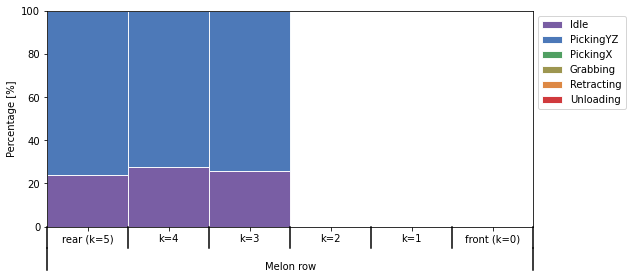

Saving 2D plot of the schedule ./plots/2dschedule.png


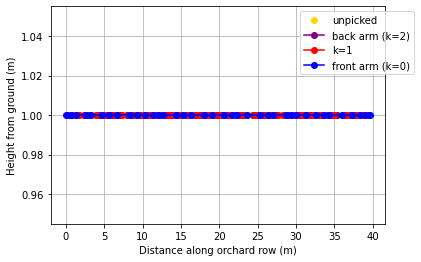

In [15]:
if __name__ == "__main__":
    # Base model
    printScen("Solving base scenario model")
    [fruit_picked_by, v_vy_cmps] = solve_melon_mip(arm, fruit, job)
    
    v_vy = v_vy_cmps / 100 # change to m/s
#     solve_melon_mip_read()
    
    total_arms = n_arm * n_row
    total_picked = np.sum(curr_j)
            
    FPE = (total_picked / numFruit)
    FPT = total_picked / (travel_l / v_vy)
    
    print()
    print('FPE:', FPE*100, '%, and FPT:', FPT, 'fruit/s')    
    print()            
    print('A total of', total_picked, 'fruits were harvested out of', numFruit)
    print('How many fruit were picked by each arm: *front* ', curr_j, ' *back*, fruit')
    print()

#     print('Sorted fruit list')
#     print(sortedFruit)
    
    # list for when there are multiple snapshots over the length of travel
    snapshot_list = list()
    snapshot_cell = list()
    
    # calculate how long each arm was working vs idle
    state_time = calcStateTime(fruit_picked_by, travel_l, v_vy, total_arms, n_row, n_arm, Td)

    # fill in snapshot object and list with current results
    snapshot = Snapshot(n_arm, n_row, horizon_l, vehicle_l, cell_l, v_max, a_max, set_algorithm, Td, v_vy, FPE, FPT, y_lim, numFruit, curr_j, sortedFruit, fruit_picked_by, state_time)
    snapshot_list.append(snapshot)
    ## continue filling if needed: PCT, state_time, fruit_picked_by, fruit_list (all lists?)
    
    horizon_indexes = getHorizonIndex(sortedFruit, q_vy, vehicle_l, horizon_l)
    print(horizon_indexes)

    ## calculate multiple R and v_vy values based on multiple slices of the current view
    # return a list of fruit densities in each cell
    d = calcDensity(q_vy, v_vy, n_row, n_arm, cell_l, cell_h, arm_reach, sortedFruit)
    # print()
    ## I wonder if calculating the max number of fruit in a bunch would help...

    ## using the fruit densities, determine the vehicle speed to set a specific R value?
    # currently, the R value would be 
    R = calcR(v_vy, len(horizon_indexes), horizon_l, vehicle_h, arm_reach)  # calculated based on columns and the horizon length

    snapshot_cell.append([d, R])

    # # combine the results based on the various snapshots taken
    results = IG_data_analysis(snapshot_list, snapshot_cell, travel_l, y_lim, set_algorithm, print_out)
    if print_out == 1:
        results.printSettings()

#     [realFPE, realFPT] = results.realFPEandFPT(sortedFruit, y_lim, v_vy)
    results.avgFPTandFPE()
    # results.avgPCT()
    # print()
    # results.plotValuesOverDistance()
    if plot_out == 1:
        results.plotTotalStatePercent()

        snapshot_schedules_2_plot = range(n_snapshots)  
        results.plot2DSchedule(snapshot_schedules_2_plot)